In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

pd.set_option('display.max_columns', 20)
plt.style.use(['dark_background'])
%matplotlib inline

In [3]:
peers = pd.read_csv("peers.csv")

In [4]:
X_variables = ["country", "date_published","review_count", "route", "seat_type",\
               "traveller_type", "days_after_crash", "airline_code"]
y_variable = ["recommended"]

In [5]:
data = peers[X_variables + y_variable]

In [6]:
display(data.head(1))

,country,date_published,review_count,route,seat_type,traveller_type,days_after_crash,airline_code,recommended
0,Australia,2018-07-12,0,Florence to London via Dusseldorf,Economy Class,Solo Leisure,1206,air-berlin,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aeec1d0>,
      dtype=object)

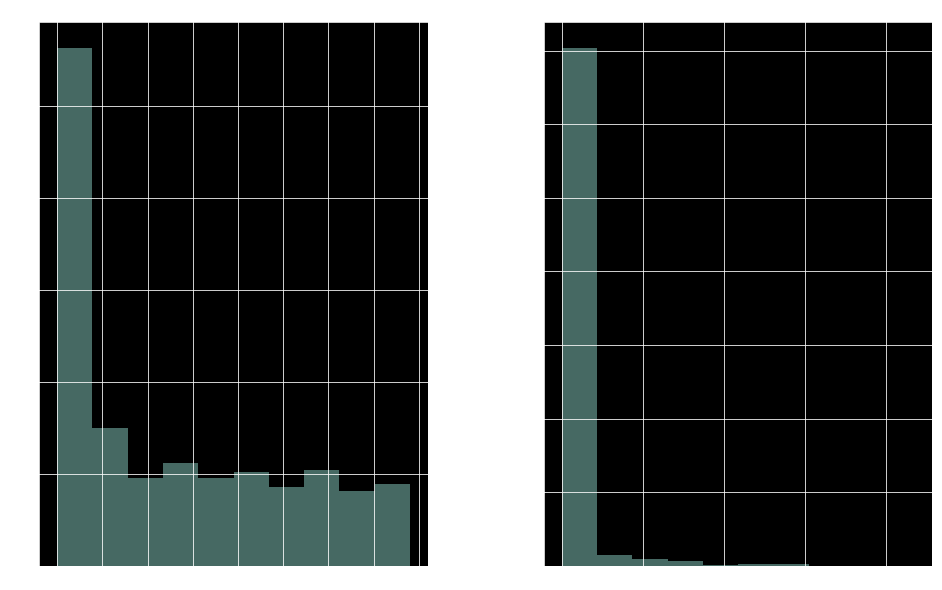

In [6]:
# Split the data into features and target label
recommended = data['recommended']
features_raw = data.drop('recommended', axis = 1)

# Visualize skewed continuous features of original data
features_raw.hist(alpha=0.5, figsize=(16, 10))


### Transforming Skewed Continuous Features


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aeec908>,
      dtype=object)

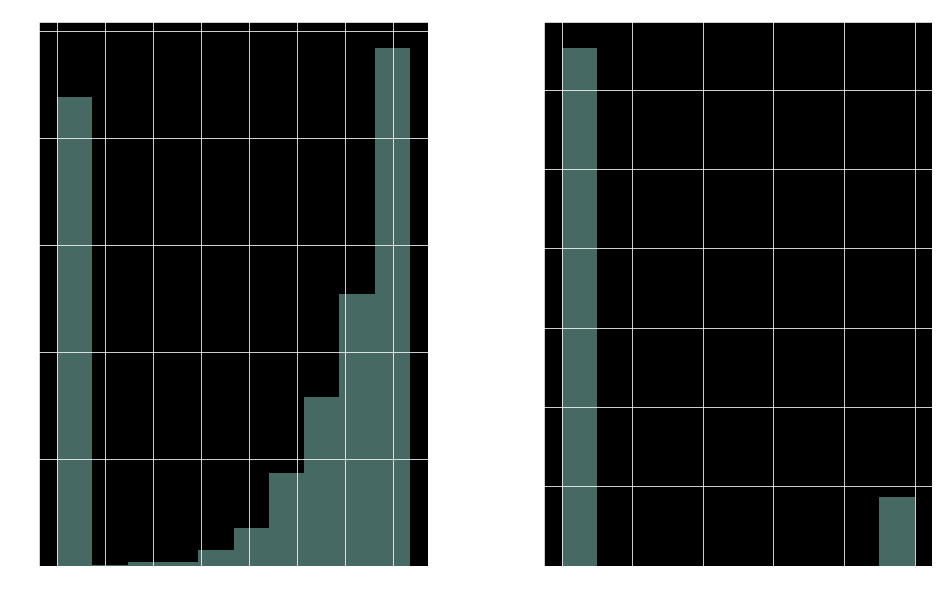

In [8]:
# Log-transform the skewed features
skewed = ['days_after_crash', 'review_count']
features_transformed = pd.DataFrame(data = features_raw)
features_transformed['days_after_crash'] = features_raw['days_after_crash'].apply(lambda x: np.log(x + 1))
features_transformed['review_count'] = (features_raw['review_count'] > 0).astype(np.float32)

# Visualize the new log distributions
features_transformed.hist(alpha=0.5, figsize=(16, 10))

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['days_after_crash'] 

features_log_minmax_transform = pd.DataFrame(data = features_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,country,date_published,review_count,route,seat_type,traveller_type,days_after_crash,airline_code
0,Australia,2018-07-12,0.0,Florence to London via Dusseldorf,Economy Class,Solo Leisure,0.964939,air-berlin
1,Netherlands,2017-10-23,1.0,Düsseldorf to Catania via Rome,Economy Class,Family Leisure,0.931662,air-berlin
2,United States,2017-10-19,0.0,Milan to New York via Dusseldorf,Economy Class,Family Leisure,0.931085,air-berlin
3,France,2017-10-17,0.0,Berlin to Prague,Economy Class,Business,0.930796,air-berlin
4,India,2017-09-19,0.0,Frankfurt to Berlin,Economy Class,Solo Leisure,0.926679,air-berlin


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted.

In [10]:
#One-hot encode the 'features_log_minmax_transform' data
features_final = pd.get_dummies(features_log_minmax_transform)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


5530 total features after one-hot encoding.


In [11]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    recommended, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 5914 samples.
Testing set has 1479 samples.


In [12]:
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    from sklearn.metrics import accuracy_score, fbeta_score
    from time import time

    results = {}
    
    # Fit the learner to the training data     
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
        
    # Predictions on the test set(X_test) and on the first 300 training
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,  beta = 1)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 1)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# T number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.10*len(y_train))
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 59 samples.
LogisticRegression trained on 591 samples.
LogisticRegression trained on 5914 samples.
RandomForestClassifier trained on 59 samples.
RandomForestClassifier trained on 591 samples.
RandomForestClassifier trained on 5914 samples.
AdaBoostClassifier trained on 59 samples.
AdaBoostClassifier trained on 591 samples.
AdaBoostClassifier trained on 5914 samples.


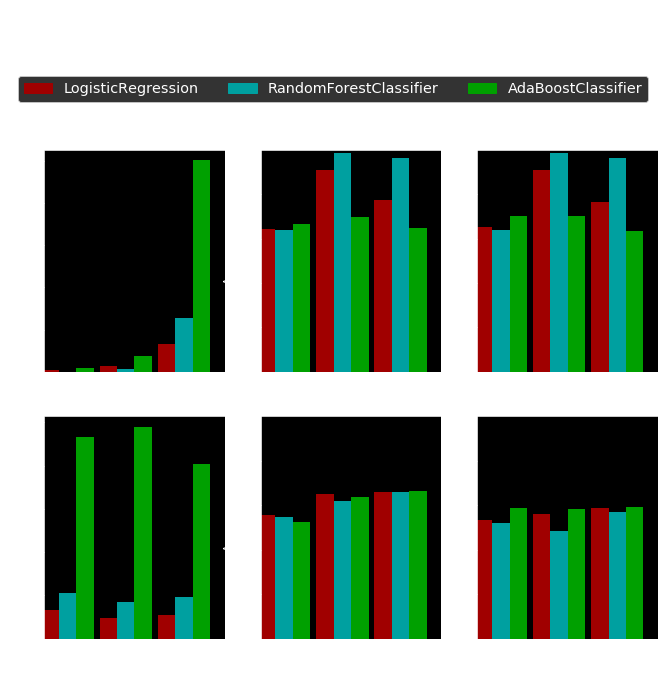

In [14]:
# Run metrics visualization for the three supervised learning models chosen
import visuals as vs
vs.evaluate(results)

### Implementation: Model Tuning


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

# Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# Parameters list to tune
parameters = { 
    "n_estimators" : [50, 200], 
    "learning_rate": [0.4, 0.7]
}

#[
#    {'classifier' : [LogisticRegression(random_state=0)],
#     'classifier__penalty' : ['l1', 'l2'],
#    'classifier__C' : np.logspace(-4, 4, 20),
#    'classifier__solver' : ['liblinear']},
#    {'classifier' : [RandomForestClassifier(random_state=0)],
#    'classifier__n_estimators' : list(range(10,101,10)),
#    'classifier__max_features' : list(range(6,32,5))}
#]

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=1)

grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

# Predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))

Final accuracy score on the testing data: 0.6606
Final F1-score on the testing data: 0.5803


## Feature Importance


In [17]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.4, n_estimators=50, random_state=0)

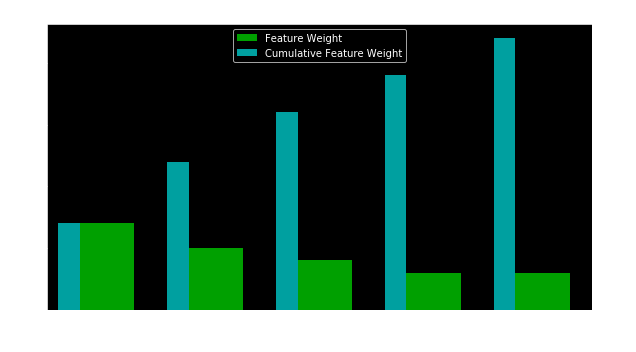

['days_after_crash' 'review_count' 'traveller_type_Business'
 'airline_code_vueling-airlines' 'airline_code_klm-royal-dutch-airlines']


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

model = best_clf
importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)

indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]
print(columns)

# Feature Selection

In [19]:
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

clf = (clone(best_clf)).fit(X_train_reduced, y_train)

reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F1-score on testing data: {:.4f}".format(f1_score(y_test, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F1-score on testing data: {:.4f}".format(f1_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.6606
F1-score on testing data: 0.5803

Final Model trained on reduced data
------
Accuracy on testing data: 0.6572
F1-score on testing data: 0.5813


Next step:
Change dates: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekofyear.html
What are the these coefficients for germanwings?